# Recommender System

Blah blah blah

## Import Libraries and Define File Paths

In [1]:
import scipy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import threadpoolctl
from collections import defaultdict
from implicit.als import AlternatingLeastSquares as ALS
from math import log2 as log
from scipy.spatial import distance
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from implicit.evaluation import (AUC_at_k,
                                 mean_average_precision_at_k,
                                 ndcg_at_k, precision_at_k)
from implicit.evaluation import train_test_split



dir = "../dataset/utility"

def load_dataset():
    items_df = pd.read_csv(f"{dir}/itemset_preprocessed.csv")
    items_df.set_index("ASIN", inplace=True)
 
    df_utility = pd.read_csv(f"{dir}/utility_topn.csv", index_col=0)
    df_utility.set_index("reviewerID", inplace=True)

    reviews_df = pd.read_csv(f"{dir}/reviews.csv")
    reviews_df.set_index('reviewerID', inplace=True)
    
    asins_df = pd.read_csv(f"{dir}/asin_product_mapping.csv")
    asins_df.set_index('ASIN', inplace=True)

    print(f"shape of df_utility: {df_utility.shape}")
    print(f"shape of items_df: {items_df.shape}")
    print(f"shape of asins_df: {asins_df.shape}")
    return items_df, df_utility, reviews_df, asins_df

## Load Dataset

In [2]:
items_df, df_utility, reviews_df, asins_df = load_dataset()

shape of df_utility: (445, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)


# Try all algorithms
We try all algorithms and evaluate the quality of recommendations.
* Neighborhood-based collaborative filtering
    * KNNBasic
    * KNNWithMeans
    * SVD
* Latent-factor based collaborative filtering
    * Alternating Least Squares (ALS)
* Content-based collaborative filtering
    * User profile numeric aggregation with Euclidean distance

## Neighborhood-based Collaborative Filtering

From Surprise

In [3]:
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(melted_user_df, reader)
algos = [KNNBasic(verbose=False), KNNWithMeans(verbose=False), SVD()]

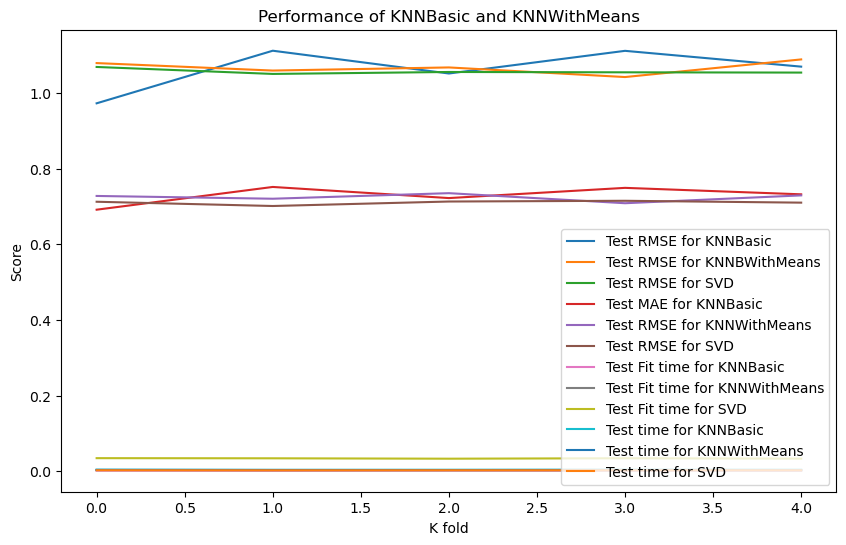

In [4]:
metrics_list = []
for algo in algos:
    metrics = cross_validate(algo, dataset)
    metrics['mean_test_rmse'] = np.mean(metrics['test_rmse'])
    metrics['mean_test_mae'] = np.mean(metrics['test_mae'])
    metrics_list.append(metrics)

k = range(0,5)
plt.figure(figsize=(10, 6))
plt.plot(k, metrics_list[0]['test_rmse'], label='Test RMSE for KNNBasic')
plt.plot(k, metrics_list[1]['test_rmse'], label='Test RMSE for KNNBWithMeans')
plt.plot(k, metrics_list[2]['test_rmse'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['test_mae'], label='Test MAE for KNNBasic')
plt.plot(k, metrics_list[1]['test_mae'], label='Test RMSE for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_mae'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['fit_time'], label='Test Fit time for KNNBasic')
plt.plot(k, metrics_list[1]['fit_time'], label='Test Fit time for KNNWithMeans')
plt.plot(k, metrics_list[2]['fit_time'], label='Test Fit time for SVD')
plt.plot(k, metrics_list[0]['test_time'], label='Test time for KNNBasic')
plt.plot(k, metrics_list[1]['test_time'], label='Test time for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_time'], label='Test time for SVD')
plt.xlabel("K fold")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.title("Performance of KNNBasic and KNNWithMeans")
plt.show()

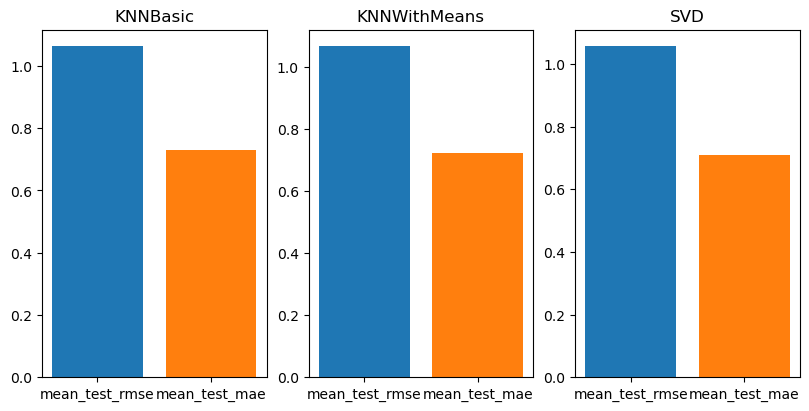

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in metrics_list:
    for k in m:
        if 'mean' in k:
            axes[ind].bar(k, m[k])
            axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Precision and Recall

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py

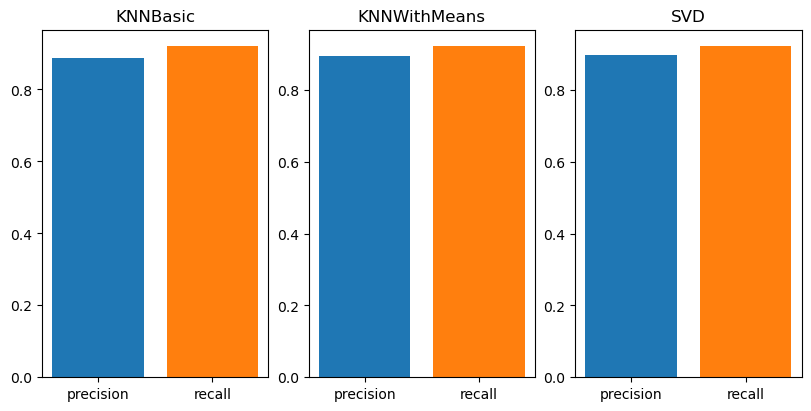

In [6]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls
kf = KFold(n_splits=5)

algo_res = []
for algo in algos:
    res_dict = {'precision': [], 'recall': []}
    for trainset, testset in kf.split(dataset):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
        res_dict['precision'].append(sum(prec for prec in precisions.values()) / len(precisions))
        res_dict['recall'].append(sum(rec for rec in recalls.values()) / len(recalls))
    algo_res.append(res_dict)


fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in algo_res:
    for k in m:
        axes[ind].bar(k, m[k])
        axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Get TopN Recommendations For All Users

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py

In [7]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
testset = trainset.build_anti_testset()
predictions = algos[2].test(testset)
top_n = get_top_n(predictions, n=10)
recommendations = {}
for uid, user_ratings in top_n.items():
    recommendations[uid] = [iid for (iid, _) in user_ratings]

### Pick out users and explore their history and recommendations

In [ ]:
def get_random_users(lst, n):
    rand_ids = random.choices(lst, k=n)
    return rand_ids


def get_ilocs(df_utility, userids):
    userids_ilocs = []
    original_indices = df_utility.index
    for u in userids:
        userids_ilocs.append(original_indices.get_loc(u))
    return userids_ilocs


userids = get_random_users(list(recommendations.keys()), len(list(recommendations.keys())))
userids_ilocs = get_ilocs(df_utility, userids)
for user_id in userids:
    #print(f"user history: {user_id}")
    #display(reviews_df.loc[[user_id]][['ProductName', 'reviewRating']])
    reco_list = recommendations[user_id]
    #print("recommended items")
    #display(asins_df.loc[reco_list])
    #print('\n')

## Latent-factor based Collaborative Filtering

### ALS

100%|██████████| 394/394 [00:00<00:00, 2448.94it/s]


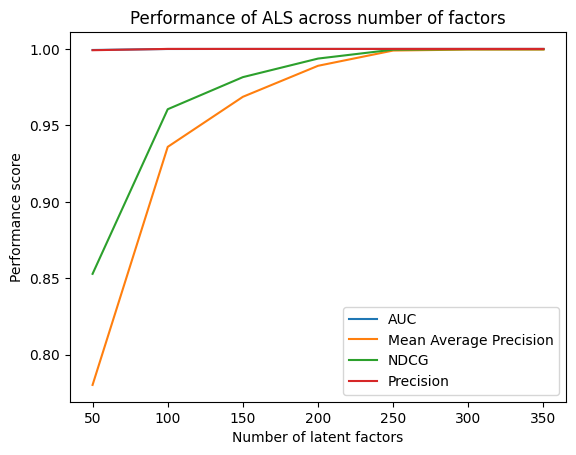

In [ ]:
csr_utility = scipy.sparse.csr_matrix(df_utility.fillna(0).values)
!export OPENBLAS_NUM_THREADS=1
threadpoolctl.threadpool_limits(1, "blas")

auc_list = []
mean_ave_precision_list = []
ndcg_list = []
precision_list = []

factors = [50, 100, 150, 200, 250, 300,
           350]

for factor in factors:
    model = ALS(
        factors=factor,
        regularization=0.05,
        alpha=1.5,
        use_cg=True,
        iterations=20,
        random_state=143
    )
    model.fit(csr_utility, show_progress=False)

    # evaluation
    training_set, test_set = train_test_split(
        csr_utility,
        train_percentage=0.85,
        random_state=143
    )
    auc = AUC_at_k(model,training_set,test_set,
                K=len(df_utility), show_progress=True)
    mean_ave_precision = mean_average_precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    ndcg = ndcg_at_k(model, training_set, test_set,
                K=len(df_utility), show_progress=True)
    precision = precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    auc_list.append(auc)
    mean_ave_precision_list.append(mean_ave_precision)
    ndcg_list.append(ndcg)
    precision_list.append(precision)

plt.plot(factors, auc_list, label='AUC')
plt.plot(factors, mean_ave_precision_list, label='Mean Average Precision')
plt.plot(factors, ndcg_list, label='NDCG')
plt.plot(factors, precision_list, label='Precision')
plt.xlabel('Number of latent factors')
plt.ylabel('Performance score')
plt.title("Performance of ALS across number of factors")
plt.legend()
plt.show()

Select `factors=250`

In [ ]:
model = ALS(
    factors=250,
    regularization=0.05,
    alpha=1.5,
    calculate_training_loss=False,
    use_cg=True,
    iterations=20,
    random_state=143
)
model.fit(csr_utility, show_progress=False)

ids, scores = model.recommend(userids_ilocs, csr_utility[userids_ilocs])
recommendations = [(x, y, z) for x, y, z in zip(userids_ilocs, ids, scores)]

def show_user_history_and_recos_als(recommendations, reviews_df, asins_df, df_utility):
    """
    Display user purchase history and recommendations
    """
    for user_ind, reco_ids, scores in recommendations:
        reviewer_id = df_utility.iloc[user_ind, :].name
        #print(f"user history: {reviewer_id}")
        #display(reviews_df.loc[reviewer_id].drop([
        #    "Unnamed: 0", "reviewDate", "reviewLocation", "reviewVotes"
        #], axis=1))
        #print("recommendations")
        inds = df_utility.columns[reco_ids]
        df_reco = asins_df.loc[inds]
        df_reco['score'] = scores
        #display(df_reco)
        
show_user_history_and_recos_als(recommendations, reviews_df, asins_df, df_utility)

## Content-based Recommender Systems

* Basic content-based recommender system using numerical user profile aggregation. Try cosine, euclidean, and jaccard distance metrics
* Hybrid recommender using LightFM

We first use a basic content-based recommender system that relies on aggregating the numeric user profile and various distance metrics such as cosine, euclidean, and jaccard. Then, we compare the results to a Hybrid Recommender System as provided by the LightFM library.

### Content-Based Recommender

* Use numerical user profile aggregation
* Try different distance metrics such as cosine, euclidean, and Jaccard distance

In [ ]:
def get_user_profile(reviewerID, df_utility, items_df):
    """
    Return series representing aggregated user profile
    """
    user_ratings = df_utility.loc[reviewerID]
    user_ratings_nonnan = user_ratings[user_ratings.notnull()]
    user_ratings_nonnan = user_ratings_nonnan[user_ratings_nonnan != 0]
    mean = np.mean(user_ratings_nonnan)
    mean_centered_user_ratings = user_ratings_nonnan - mean
    nonnan_asins = mean_centered_user_ratings.index.tolist()
    dotprod = np.dot(mean_centered_user_ratings, items_df.loc[nonnan_asins])
    return dotprod, nonnan_asins


def get_recommendations(user_profile, items_df,
        n, user_history, eval, dist):
    """
    Return dictionary of sorted recommendations
    """
    if dist == 'cos':
        dist_func = distance.cosine
    if dist == 'euc':
        dist_func = distance.euclidean
    if dist == 'jac':
        dist_func = distance.jaccard
    similarities = {}
    for ind, feats in items_df.iterrows():
        if ind not in user_history:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
        if eval:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
    sorted_similarites = dict(sorted(
        similarities.items(), key=lambda item: item[1], reverse=False)[:n])
    normalized_scores = normalize_ratings(pd.Series(sorted_similarites.values()))
    for key, value in zip(sorted_similarites.keys(), normalized_scores):
        sorted_similarites[key] = value
    return sorted_similarites


def normalize_ratings(recommendations):
    """
    Return mapped ratings. We do this because the scoring
    for user_history and recommendations are in different ranges 
    """
    return (
        recommendations - recommendations.min()) / (
            recommendations.max() - recommendations.min()) * (0 - 5) + 5


def dcg(user_history, recommendations):
    """
    Return dcg for this user given their history
    and recommendations
    """
    ranking = 1
    dcg_final = 0
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'reviewRating']].set_index('ASIN').to_dict()['reviewRating']
    for key, value in recommendations.items():
        dcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return dcg_final / len(recommendations)


def idcg(user_history, recommendations):
    """
    Return ndcg for this user given their history
    and recommendations
    """
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'reviewRating']].set_index('ASIN').to_dict()['reviewRating']
    ranking = 1
    idcg_final = 0
    for key in actual_ratings.keys():
        idcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return idcg_final / len(recommendations)


def basic_content_based_recommender(
    userids, df_utility, items_df,
    reviews_df, asins_df, n, eval, dist):
    """
    Return recommendations for the list of users.

    Parameters:
    userids: STRING list
    df_utility: DataFrame representing the utility matrix
    items_df: DataFrame representing the itemset
    reviews_df: DataFrame representing user history
    asins_df: DataFrame that contains mapping between ASINs and Product Names
    n: INTEGER Number of recommendations to output
    dist: STRING distance function to be used
    """
    recommendations = {}
    ndcg = None
    if eval:
        dcg_list = []
        idcg_list = []
        ndcg_list = []
    for user in userids:
        user_profile, nonnan_asins = get_user_profile(user, df_utility, items_df)
        user_history_df = reviews_df.loc[user].drop([
            "Unnamed: 0", "reviewDate", "reviewLocation", "reviewVotes"
        ], axis=1)
        user_history_df = user_history_df.sort_values('reviewRating', ascending=False)
        if eval:
            recos = get_recommendations(
                user_profile,
                items_df.loc[nonnan_asins],
                len(user_profile),
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
            dcg_list.append(dcg(user_history_df, recos))
            idcg_list.append(idcg(user_history_df, recos))
        else:
            recos = get_recommendations(
                user_profile,
                items_df,
                n,
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
        recommendations[user] = recos
        #print(f"sorted user history: {user}")
        #display(user_history_df)
        #print(f"recommended items")
        df_reco = asins_df.loc[list(recos.keys())]
        df_reco['normalized_relevance_score'] = pd.Series(recommendations[user])
        #display(df_reco)
    if eval:
        dcg_final = np.mean(dcg_list)
        idcg_final = np.mean(idcg_list)
        ndcg = dcg_final / idcg_final
        ndcg_list.append(ndcg)
        #print(f"ndcg for this user is given by: {ndcg}")
    return recommendations, ndcg_list

## Evaluation: NDCG @ K=10

Get average NDCG across all users. Compare NDCG across different distance metrics.

In [ ]:
dist_config = ['euc', 'cos', 'jac']
for d in dist_config:
    recommendations, ndcg_list = basic_content_based_recommender(
        userids, df_utility, items_df.copy(),
        reviews_df, asins_df, 10, True, d)
    print(f"average ndcg with distance metric {d} is {np.mean(ndcg_list)}")

average ndcg with distance metric euc is 0.9950556813059024


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  

average ndcg with distance metric cos is 0.9947404550193445
average ndcg with distance metric jac is 0.94960197259136


### Hybrid Recommender Using LightFM

#### Get Top 20 Reviewers

In [8]:
non_nan_count = df_utility.notna().sum(axis=1)
df_top_reviewers = df_utility.loc[non_nan_count.sort_values(ascending=False).index].iloc[:20]
df_top_reviewers

,b085fzxzj5,b000iw9j20,b0c6rc2k82,b09xjd2znd,b07pqt144t,b086jp7fx9,b07jfl43nx,b0c44fvt2q,b0bwjz2fhw,b0c61kbpc8,...,b0cl4gxlgp,b0cpffh4pz,b0ctcy1wtr,b0cghxs3p8,b09n6xj3cl,b0bhzfpqgy,b0867bkglg,b087wp31h9,b0cjv1mjxm,b08gqxnj4y
reviewerID,,,,,,,,,,,,,,,,,,,,,
Chris_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
David_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Laura_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maria_,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sarah_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alex_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cliente Kindle_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andrea_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Daniel_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Export User History and Recommendations as Pickle file

In [25]:
user_hist_reco_dict={}
for algo in algos:
    algo_name = algo.__class__.__name__
    user_hist_reco_dict[algo_name] = {}
    predictions = algo.test(testset)
    top_n = get_top_n(predictions, n=10)
    recommendations = {}
    for uid, user_ratings in top_n.items():
        recommendations[uid] = [iid for (iid, _) in user_ratings]    
    for user, row in df_top_reviewers.iterrows():
        df_user_hist = reviews_df.loc[[user]][['ASIN','ProductName', 'reviewRating']]
        reco_list = recommendations[user]
        df_reco = asins_df.loc[reco_list]
        # Add the tuple (reviews_subset, df_reco) to the dictionary with reviewer_id as the key
        user_hist_reco_dict[algo_name][user] = (df_user_hist, df_reco)
display(user_hist_reco_dict)   
# Save the dictionary to a pickle file
pd.to_pickle(user_hist_reco_dict, 'user_hist_reco.pkl')

{'KNNBasic': {'Chris_': (                  ASIN                                        ProductName  \
   reviewerID                                                                  
   Chris_      b0byn7f7y2  daybetter_led_strip_lights_130ft_2_rolls_of_65...   
   Chris_      b08k3j7ffb  reset_hdd_button_switchgelrhonr_desktop_pc_com...   
   Chris_      b07tyvv4py  comeap_cpu_8_pin_female_to_cpu_8_pin_atx_4_pin...   
   Chris_      b075x3287p  nuwave_brio_10in1_air_fryer_725qt_with_patente...   
   Chris_      b08qq6kwyn  deco_chef_37_qt_personal_digital_air_fryer_7_o...   
   ...                ...                                                ...   
   Chris_      b09sg2bvzx  selfie_stick_phone_tripod_with_remote_and_led_...   
   Chris_      b0cphkymv5  k&f_concept_metal_mini_phone_camera_tripod_1/4...   
   Chris_      b005dw9ioe  ashton_4in1_convertible_crib_in_cherry_greengu...   
   Chris_      b0brq4grg6  jack_rose_travel_mirror_with_light_travel_make...   
   Chris_      b0b